In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense

In [2]:
lines = open('fra.txt', encoding='utf-8').read().strip().split('\n')

In [3]:
sentence_pairs = [line.split('\t')[:2] for line in lines]
english_sentences, french_sentences = zip(*sentence_pairs)

In [4]:
french_sentences = ['<start> ' + sent + ' <end>' for sent in french_sentences]

In [5]:
#Tokenize the sentences
def tokenize(lang_sentences):
    tokenizer = Tokenizer(filters='')
    tokenizer.fit_on_texts(lang_sentences)
    tensor = tokenizer.texts_to_sequences(lang_sentences)
    tensor = pad_sequences(tensor, padding='post')
    return tensor, tokenizer

input_tensor, inp_tokenizer = tokenize(english_sentences)
target_tensor, targ_tokenizer = tokenize(french_sentences)

In [6]:
# Step 5: Check shapes
print(f"Input Tensor Shape: {input_tensor.shape}")
print(f"Target Tensor Shape: {target_tensor.shape}")

Input Tensor Shape: (237838, 55)
Target Tensor Shape: (237838, 58)


* Build Encoder and Decoder using LSTM (Keras) *

In [7]:
embedding_dim = 128
lstm_units = 256
vocab_inp_size = len(inp_tokenizer.word_index) + 1
vocab_tar_size = len(targ_tokenizer.word_index) + 1
max_length_input = input_tensor.shape[1]
max_length_target = target_tensor.shape[1]

In [8]:
# ENCODER
encoder_input = Input(shape=(None,))
enc_emb = Embedding(vocab_inp_size, embedding_dim)(encoder_input)
encoder_lstm, state_h, state_c = LSTM(lstm_units, return_state=True)(enc_emb)
encoder_states = [state_h, state_c]

In [9]:
# DECODER
decoder_input = Input(shape=(None,))
dec_emb_layer = Embedding(vocab_tar_size, embedding_dim)
dec_emb = dec_emb_layer(decoder_input)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_output, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(vocab_tar_size, activation='softmax')
output = decoder_dense(decoder_output)

In [10]:
model = Model([encoder_input, decoder_input], output)

In [11]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, None, 128)         │       3,965,952 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, None, 128)         │       7,023,744 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ [(None, 256), (None,      │         394,240 │ embedding[0][0]            │
│                               │ 256), (None, 256)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ [(None, None, 256),       │         394,240 │ embedding_1[0][0],         │
│                               │ (None, 256), (None, 256)] │                 │ lstm[0][1], lstm[0][2]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, None, 54873)       │      14,102,361 │ lstm_1[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 25,880,537 (98.73 MB)

 Trainable params: 25,880,537 (98.73 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
decoder_input_data = target_tensor[:, :-1]
decoder_target_data = target_tensor[:, 1:]
decoder_target_data = np.expand_dims(decoder_target_data, -1) 

In [14]:
sample_size = 10000

input_tensor_small = input_tensor[:sample_size]
decoder_input_data_small = decoder_input_data[:sample_size]
decoder_target_data_small = decoder_target_data[:sample_size]

history = model.fit(
    [input_tensor_small, decoder_input_data_small],
    decoder_target_data_small,
    batch_size=64,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 517s 4s/step - loss: 4.1413 - val_loss: 0.5105
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 499s 4s/step - loss: 0.4166 - val_loss: 0.4609
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 639s 5s/step - loss: 0.3781 - val_loss: 0.4384
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 631s 5s/step - loss: 0.3553 - val_loss: 0.4263
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 467s 4s/step - loss: 0.3363 - val_loss: 0.4187
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 380s 3s/step - loss: 0.3266 - val_loss: 0.4121
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 379s 3s/step - loss: 0.3171 - val_loss: 0.4091
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 385s 3s/step - loss: 0.3081 - val_loss: 0.4064
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 452s 4s/step - loss: 0.3007 - val_loss: 0.4056
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 520s 4s/step - loss: 0.2946 - val_loss: 0.4018


In [15]:
model.save("eng_fra_translation_model.h5")

In [16]:
encoder_model = Model(encoder_input, encoder_states)

decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_input)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=decoder_states_inputs
)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_input] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

In [17]:
def decode_sequence(input_seq):

    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = targ_tokenizer.word_index['<start>']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = targ_tokenizer.index_word.get(sampled_token_index, '')

        if (sampled_word == '<end>' or len(decoded_sentence.split()) > max_length_target):
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]

    return decoded_sentence.strip()

In [18]:
def evaluate(sentence):
    sentence_seq = inp_tokenizer.texts_to_sequences([sentence])
    sentence_seq = pad_sequences(sentence_seq, maxlen=max_length_input, padding='post')
    return decode_sequence(sentence_seq)

In [19]:
sentence = "hello"
translated = evaluate(sentence.lower())
print(f"📝 Input   : {sentence}")
print(f"🔁 Output  : {translated}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
📝 Input   : hello
🔁 Output  : je suis pas ?


In [20]:
sentence = "how are you?"
translated = evaluate(sentence.lower())
print(f"📝 Input   : {sentence}")
print(f"🔁 Output  : {translated}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
📝 Input   : how are you?
🔁 Output  : je suis pas ?


In [21]:
sentence = "i love you"
translated = evaluate(sentence.lower())
print(f"📝 Input   : {sentence}")
print(f"🔁 Output  : {translated}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
📝 Input   : i love you
🔁 Output  : je suis pas ?


In [22]:
sentence = "thank you"
translated = evaluate(sentence.lower())
print(f"📝 Input   : {sentence}")
print(f"🔁 Output  : {translated}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
📝 Input   : thank you
🔁 Output  : je suis pas ?


In [30]:
sentence = "run"
translated = evaluate(sentence.lower())
print(f"📝 Input   : {sentence}")
print(f"🔁 Output  : {translated}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
📝 Input   : run
🔁 Output  : je suis pas ?


In [23]:
sentence = "what is your name?"
translated = evaluate(sentence.lower())
print(f"📝 Input   : {sentence}")
print(f"🔁 Output  : {translated}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
📝 Input   : what is your name?
🔁 Output  : je suis pas ?


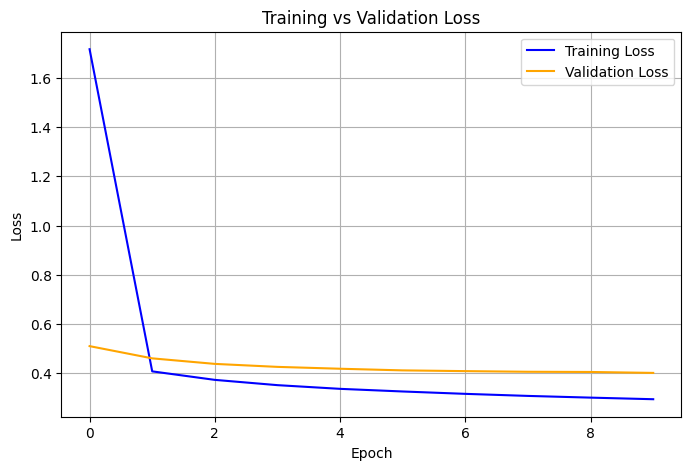

In [24]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

🔹 Overfitting:
     definition: When a model learns the training data too well, including noise, and performs poorly on new/unseen data.
     observation: There is no strong evidence of overfitting.The validation loss follows the training loss closely & remains stable across          epochs.

 🔹 Underfitting:
     definition: When a model is too simple to capture the underlying patterns in the training data, resulting in poor performance.
     observation: : There is no underfitting. The training loss decreases rapidly, and the validation loss shows improvement too.

 🔹 Training Stability:
      definition: The smooth and consistent behavior of the model’s learning process across epochs without sudden spikes or drops.
      observation: The training is stable as both training and validation loss curves are smooth and show consistent downward trends.
